---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiante: **Maynor Alvarado Cascante**
- Carné: **B80298**
- Grupo: **1**


- Estudiante: **Andrés Corrales Vargas**
- Carné: **B72400**
- Grupo: **2**


- Estudiante: **Jose Andrey Salazar Vargas**
- Carné: **B87241**
- Grupo: **2**

# `P5` - *Procesos M/M/s*

---

## 1. Determinación teórica del número $s$ de servidores necesarios para cumplir el requisito.

La longitud de la fila se obtiene con esta ecuación $L_q = i - 1$, como ya se tiene la cantidad de personas en la fila $L_q = 100$, se despeja para poder obtener el número de clientes $i$.

$$
i = L_q +1 = 100 + 1 = 101
$$

Como el sistema M/M/s tiene una cantidad $s$ de servidores posiblemente distinto de $1$, se utiliza que: $\rho = \lambda / s \nu$. Por lo tanto, es posible encontrar que:

$$
P( \text{101 o más clientes en la fila} ) = \sum_{i=101}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{100} (1 - \rho) \rho^i = \rho^{101}
$$

De los datos del problema: $\lambda = 7$ y $\nu = 0.25$. Para tener una fila de $100$ o menos clientes el $95\%$ del tiempo  (Y consecuentemente más clientes el $100\% - 95\% = 1-0.95 = 0.05$) se necesita:

$$
\begin{aligned}
P( \text{101 o más clientes en la fila} ) = \rho^{101} & = \left( \frac{\lambda}{s \nu} \right)^{101} \leq 0.05 \\
s^{101} \nu^{101} & \geq \frac{\lambda^{101}}{0.05} \\
s^{101} \geq & \frac{\lambda^{101}}{0.05 \cdot \nu^{101}} \\
s \geq  ( \frac{1}{0.05} )^{\frac{1}{101}} & \cdot ( \frac{7}{0.25} )^{\frac{101}{101}} \\
s \quad \geq & \quad 28.84  
\end{aligned}
$$

Como no existen $28.84$ personas, dicho número se redondea hacia arriba, ya que no se puede quitar el $0.84$ persona necesario para obtener lo requerido; por lo tanto, $s = 29$.

## 2. Simulación del sistema M/M/s.
A continuación, se presenta el código necesario para corroborar si el resultado teórico obtenido es el indicado.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


def vacunacion(s):
    '''
    En esta función se realiza la simulación del sistema M/M/s
    que representa el proceso de vacunación, recibiendo en el
    parámetro s la cantidad de servidores a simular. Se genera
    una gráfica con el comportamiento de la fila de vacunación
    en el tiempo, respecto al valor de fila máximo.

    :param s: Cantidad de servidores
    '''

    # Número de clientes
    N = 3150

    # Parámetro de llegada (clientes/segundos)
    lam = 7/60

    # Parámetro de servicio (servicios/segundos)
    nu = (0.25*s)/60

    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale=1/lam)

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale=1/nu)

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio)
    t_llegadas = [t_intervalos[0]]
    for i in range(1, len(t_intervalos)):
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Inicialización del tiempo de inicio y fin de atención
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]

    for i in range(1, N):
        inicio = np.max((t_llegadas[i], fin))
        fin = inicio + t_servicio[i]
        t_atencion.append(inicio)

    # Inicialización del vector temporal para registrar eventos
    t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):
        i = t_llegadas[c]
        t[i] += 1
        j = t_atencion[c] + t_servicio[c]
        t[j] -= 1

    # Umbral de P o más personas en sistema (hay P - 1 en fila)
    P = 101

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)

    # Inicialización de estado n
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c  # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P:
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('------------------------------------------------------------------')
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu total =', str(nu*60))
    print('Número de servidores =', str(s))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-1))
    print('\t {:0.2f}%'.format(100*fraccion))

    if fraccion <= 0.01:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.')

    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-1)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, 28000))
    plt.show()


------------------------------------------------------------------
Parámetro lambda = 7.0
Parámetro nu total = 7.25
Número de servidores = 29
Tiempo con más de 100 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 7.97 horas.


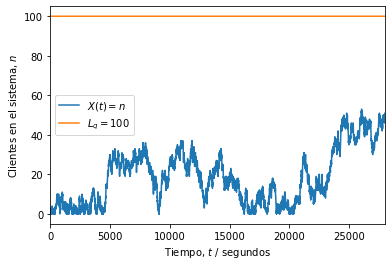

------------------------------------------------------------------
Parámetro lambda = 7.0
Parámetro nu total = 6.75
Número de servidores = 27
Tiempo con más de 100 solicitudes en fila:
	 55.08%
	 No cumple con la especificación.
Simulación es equivalente a 8.17 horas.


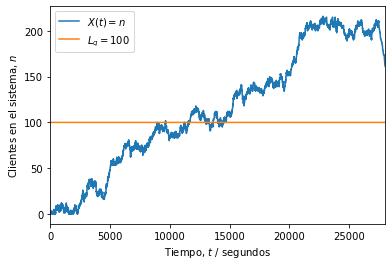

------------------------------------------------------------------
Parámetro lambda = 7.0
Parámetro nu total = 8.0
Número de servidores = 32
Tiempo con más de 100 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 7.98 horas.


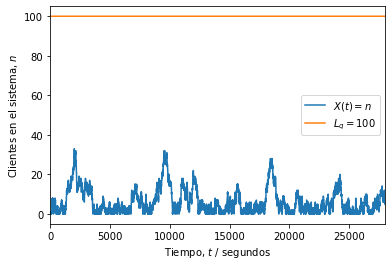

In [2]:
# Se realizan tres simulaciones para corroborar lo obtenido teóricamente:
# una con el valor exacto de servidores, otra con un valor inferior y
# otra con un valor superior de servidores.
vacunacion(29)
vacunacion(27)
vacunacion(32)


## 3. Análisis de gráficas y resultados.

En esta última sección se aborda el análisis de las gráficas obtenidas, así como los resultados.

El concepto de *servidor* es vital para el análisis de este trabajo. Los servidores corresponden a los sujetos o personas que brindan un servicio al cliente, que en este caso corresponden a las personas necesarias para el proceso de vacunación. 

Estos tardan un cierto tiempo denominado *tiempo de servicio*, el cual es un tiempo **aleatorio** pero **distribuido exponencialmente** con parámetro $\nu$ (nu) en que un servidor cumplirá su utilidad con un solo cliente. Para este proceso, este parámetro corresponde a $0.25$ personas (clientes) atendidos o vacunados por minuto. 

Se pueden tener uno o varios servidores para atender clientes. De aca surgen entonces cuatro conclusiones lógicas:

* Cuanto mayor sea la cantidad de servidores, menor es el tiempo que un cliente tenga que esperar para ser atendido.

* Como consecuencia del punto anterior, si el tiempo de espera de un cliente es menor, las colas o filas tendrán menor cantidad de personas.

* Una cantidad deficiente de servidores (caso $\lambda>s \nu$ donde $\lambda$ es la cantidad de llegadas de clientes que en este caso es de 7 personas por minuto) provocará colas o filas cada vez más grandes, al punto de inestabilidad.

* Un exceso de servidores provoca atención inmediata al cliente, tiempo de espera inmediato, no hay filas, pero por el exceso podrían haber servidores no haciendo nada, lo cual tampoco es bueno. En este caso, con servidores extra se estaría pagando personal médico demás por ejemplo.

Según el análisis matemático realizado en la **Parte 1** de este proyecto, la cantidad $s$ de servidores tal que se cumpla que el sistema no exceda $100$ personas en fila durante el $95$% del tiempo de servicio es de $29$ servidores (personal médico vacunando).

Para nuestro análisis entonces, se tomaron en cuenta tres casos diferentes donde se varió la cantidad de servidores, con el fin de poder abordar gráficamente cada uno de ellos:

1. ¿Que pasa cuando se tiene la cantidad teórica suficiente de servidores (29 servidores)?

2. ¿Qué pasa cuando se tienen menos servidores de los que se necesitan (27 servidores)?

3. ¿Qué pasa cuando se tienen más servidores de los que se necesitan (32 servidores)?

En el primer caso, cuando se tiene la cantidad teórica suficiente, se muestra en la primera gráfica obtenida una cantidad de clientes considerable, pero que en ningún momento sobrepasan la cantidad límite de 100 personas. Nótese que en este caso $\lambda<s \nu$ por una diferencia de $0.25$ y por tanto es de esperar que el comportamiento de la curva se mantenga estable, pero con afluencia considerable de personas.

Caso contrario ocurre en el segundo caso, donde se tienen menos servidores de los necesarios para cubrir la demanda. En este caso $\lambda>s\nu$ por una diferencia de $0.25$. Logicamente, al tener más llegadas que salidas, la cola se va volviendo más y más grande, hasta que llega un momento en que se alcanza la inestabilidad, y se supera la cantidad límite de 100 personas, e incluso llega a crecer mucho más, según lo mostrado en la gráfica.

Ahora bien, en el caso en que se tienen más servidores de los necesarios, nuevamente se vuelve a tener un caso en que $\lambda<s \nu$, pero esta vez con una diferencia de 1, lo cual llega a verse muy claro en la gráfica, donde se tiene una baja afluencia de personas en todo momento, ya que prácticamente, y al menos que lleguen bastantes personas (los picos de la gráfica), estas son atendidas más inmediatamente que en los casos anteriores.

*Dado lo anterior, se concluye y corrobora que efectivamente, la teoría de colas funciona muy bien para determinar en este caso cual es la cantidad óptima de servidores necesarios para el proceso de vacunación, de forma tal que el sistema no exceda 100 personas en fila durante el 95% del tiempo de servicio. Esto se puede decir con seguridad a partir de observar en las gráficas obtenidas que la afluencia de personas se mantiene en números aceptables cuando se tienen 29 servidores, se inestabiliza cuando la cantidad de servidores es menor (27 servidores), y la afluencia de personas es baja cuando hay exceso de servidores (32 servidores).*

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---